In [19]:
import os
from pathlib import Path
import ipywidgets as widgets
from warnings import simplefilter

from utils import (create_multistep_example,
                   load_multistep_data,
                   make_lags,
                   make_multistep_target,
                   plot_multistep)

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import RegressorChain
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

In [20]:
simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'

## Читаем `csv` файлы из отдельной директории

In [2]:
#Папка где у меня файлы
path = "f:\\Datasets\\kaggle-store-sales"

# ШАГ 1. Запоминаем текущую папку и меняем ее на нужную = где файл лежит
# Check current working directory.
main_path = os.getcwd()
print("Current working directory", main_path)

# Now change the directory
os.chdir( path )

# Check current working directory.
cur_path = os.getcwd()
print("Directory changed successfully",cur_path)

# ШАГ 2. Читаем файл в датафрейм df (оперативную память) для трансформации
# прочитаем файл
store_sales = pd.read_csv(
    'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date']
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017']
)    

test = pd.read_csv(
    'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date']    
)
test['date'] = test.date.dt.to_period('D')
test = test.set_index(['store_nbr', 'family', 'date']).sort_index()

# ШАГ 3. Возвращаем основную рабочую директорию 
os.chdir(main_path)
cur_path = os.getcwd()
print("Directory changed successfully", cur_path)

Current working directory g:\github_projects\study-time-series-analysis\kaggle-ts
Directory changed successfully f:\Datasets\kaggle-store-sales
Directory changed successfully g:\github_projects\study-time-series-analysis\kaggle-ts


Consider the following three forecasting tasks:
- a. 3-step forecast using 4 lag features with a 2-step lead time
- b. 1-step forecast using 3 lag features with a 1-step lead time
- c. 3-step forecast using 4 lag features with a 1-step lead time


In [4]:
datasets = load_multistep_data()

data_tabs = widgets.Tab([widgets.Output() for _ in enumerate(datasets)])
for i, df in enumerate(datasets):
    data_tabs.set_title(i, f'Dataset {i+1}')
    with data_tabs.children[i]:
        display(df)

display(data_tabs)

# 1) Match description to dataset
Can you match each task to the appropriate dataset?

answer:

task_a = 2,
task_b = 1,
task_c = 3

Look at the time indexes of the training and test sets. From this information, can you identify the forecasting task for Store Sales?

In [5]:
print("Training Data", "\n" + "-" * 13 + "\n", store_sales)
print("\n")
print("Test Data", "\n" + "-" * 9 + "\n", test)

Training Data 
-------------
                                      sales  onpromotion
store_nbr family     date                              
1         AUTOMOTIVE 2013-01-01   0.000000            0
                     2013-01-02   2.000000            0
                     2013-01-03   3.000000            0
                     2013-01-04   3.000000            0
                     2013-01-05   5.000000            0
...                                    ...          ...
9         SEAFOOD    2017-08-11  23.830999            0
                     2017-08-12  16.859001            4
                     2017-08-13  20.000000            0
                     2017-08-14  17.000000            0
                     2017-08-15  16.000000            0

[3000888 rows x 2 columns]


Test Data 
---------
                                       id  onpromotion
store_nbr family     date                            
1         AUTOMOTIVE 2017-08-16  3000888            0
                     2017-08

# 2) Identify the forecasting task for Store Sales competition
Try to identify the forecast origin and the forecast horizon. How many steps are within the forecast horizon? What is the lead time for the forecast?

answer:

The training set ends on 2017-08-15, which gives us the forecast origin. The test set comprises the dates 2017-08-16 to 2017-08-31, and this gives us the forecast horizon. There is one step between the origin and horizon, so we have a lead time of one day.

Put another way, we need a 16-step forecast with a 1-step lead time. We can use lags starting with lag 1, and we make the entire 16-step forecast using features from 2017-08-15.


In the tutorial we saw how to create a multistep dataset for a single time series. Fortunately, we can use exactly the same procedure for datasets of multiple series.

# 3) Create multistep dataset for Store Sales
Create targets suitable for the Store Sales forecasting task. Use 4 days of lag features. Drop any missing values from both targets and features.

In [6]:
# YOUR CODE HERE
y = family_sales.loc[:, 'sales']

# YOUR CODE HERE: Make 4 lag features
X = make_lags(y, lags=4).dropna()

# YOUR CODE HERE: Make multistep target
y = make_multistep_target(y, steps=16).dropna()

y, X = y.align(X, join='inner', axis=0)

In [11]:
y.columns

MultiIndex([( 'y_step_1',                 'AUTOMOTIVE'),
            ( 'y_step_1',                  'BABY CARE'),
            ( 'y_step_1',                     'BEAUTY'),
            ( 'y_step_1',                  'BEVERAGES'),
            ( 'y_step_1',                      'BOOKS'),
            ( 'y_step_1',               'BREAD/BAKERY'),
            ( 'y_step_1',                'CELEBRATION'),
            ( 'y_step_1',                   'CLEANING'),
            ( 'y_step_1',                      'DAIRY'),
            ( 'y_step_1',                       'DELI'),
            ...
            ('y_step_16',                  'MAGAZINES'),
            ('y_step_16',                      'MEATS'),
            ('y_step_16',              'PERSONAL CARE'),
            ('y_step_16',               'PET SUPPLIES'),
            ('y_step_16',    'PLAYERS AND ELECTRONICS'),
            ('y_step_16',                    'POULTRY'),
            ('y_step_16',             'PREPARED FOODS'),
            ('y

In [9]:
y.head()

y_step_1                                              \
family     AUTOMOTIVE BABY CARE     BEAUTY    BEVERAGES     BOOKS   
date                                                                
2017-01-05   6.333333  0.351852   5.925926  3258.796387  0.407407   
2017-01-06   6.018518  0.277778   6.518518  3507.277832  0.537037   
2017-01-07  10.259259  0.259259  10.037037  4848.518555  0.481481   
2017-01-08   9.388889  0.240741  11.611111  5503.647949  0.722222   
2017-01-09   5.944445  0.444444   5.648148  3448.203613  0.500000   

                                                                           \
family     BREAD/BAKERY CELEBRATION     CLEANING        DAIRY        DELI   
date                                                                        
2017-01-05   495.511597   12.444445  1241.833374   829.277771  260.776489   
2017-01-06   513.873291   18.333334  1257.611084   864.333313  317.622406   
2017-01-07   649.424133   21.444445  1761.351807  1173.463013  381.874756   
2017-01-08   776.717834   10.925926  1784.018555  1323.314819  429.561798   
2017-01-09   535.816040    9.240741  1208.018555   883.685181  284.767456   

            ...  y_step_16                                         \
family      ...  MAGAZINES       MEATS PERSONAL CARE PET SUPPLIES   
date        ...                                                     
2017-01-05  ...   6.537037  512.165527    233.611115     6.444445   
2017-01-06  ...  10.444445  402.395264    420.944458    11.314815   
2017-01-07  ...   8.648149  413.076538    462.462952    12.462963   
2017-01-08  ...   7.037037  310.008514    311.888885     6.962963   
2017-01-09  ...   5.259259  300.459290    323.500000     5.814815   

                                                                            \
family     PLAYERS AND ELECTRONICS     POULTRY PREPARED FOODS      PRODUCE   
date                                                                         
2017-01-05                8.648149  513.483887     106.494164  2006.322021   
2017-01-06               16.148148  489.485840     143.066299  2849.252930   
2017-01-07               18.351852  525.847107     141.927856  3101.657715   
2017-01-08               11.518518  370.790070      97.506241  2168.730225   
2017-01-09                9.370370  326.745636      97.317223  2247.617920   

                                                  
family     SCHOOL AND OFFICE SUPPLIES    SEAFOOD  
date                                              
2017-01-05                   0.944444  25.899963  
2017-01-06                   1.944444  26.443592  
2017-01-07                   3.555556  29.259481  
2017-01-08                   1.740741  20.695278  
2017-01-09                   1.629630  17.374334  

[5 rows x 528 columns]

In [12]:
X.columns

MultiIndex([('y_lag_1',                 'AUTOMOTIVE'),
            ('y_lag_1',                  'BABY CARE'),
            ('y_lag_1',                     'BEAUTY'),
            ('y_lag_1',                  'BEVERAGES'),
            ('y_lag_1',                      'BOOKS'),
            ('y_lag_1',               'BREAD/BAKERY'),
            ('y_lag_1',                'CELEBRATION'),
            ('y_lag_1',                   'CLEANING'),
            ('y_lag_1',                      'DAIRY'),
            ('y_lag_1',                       'DELI'),
            ...
            ('y_lag_4',                  'MAGAZINES'),
            ('y_lag_4',                      'MEATS'),
            ('y_lag_4',              'PERSONAL CARE'),
            ('y_lag_4',               'PET SUPPLIES'),
            ('y_lag_4',    'PLAYERS AND ELECTRONICS'),
            ('y_lag_4',                    'POULTRY'),
            ('y_lag_4',             'PREPARED FOODS'),
            ('y_lag_4',                    'PRODU

In [10]:
X.head()

y_lag_1                                              \
family     AUTOMOTIVE BABY CARE     BEAUTY    BEVERAGES     BOOKS   
date                                                                
2017-01-05   6.833333  0.333333   6.888889  3911.833252  0.759259   
2017-01-06   6.333333  0.351852   5.925926  3258.796387  0.407407   
2017-01-07   6.018518  0.277778   6.518518  3507.277832  0.537037   
2017-01-08  10.259259  0.259259  10.037037  4848.518555  0.481481   
2017-01-09   9.388889  0.240741  11.611111  5503.647949  0.722222   

                                                                           \
family     BREAD/BAKERY CELEBRATION     CLEANING        DAIRY        DELI   
date                                                                        
2017-01-05   594.160583   11.185185  1508.036987  1107.796265  309.397675   
2017-01-06   495.511597   12.444445  1241.833374   829.277771  260.776489   
2017-01-07   513.873291   18.333334  1257.611084   864.333313  317.622406   
2017-01-08   649.424133   21.444445  1761.351807  1173.463013  381.874756   
2017-01-09   776.717834   10.925926  1784.018555  1323.314819  429.561798   

            ...   y_lag_4                                         \
family      ... MAGAZINES       MEATS PERSONAL CARE PET SUPPLIES   
date        ...                                                    
2017-01-05  ...  0.074074    5.013166      2.629630     0.074074   
2017-01-06  ...  7.777778  488.522339    714.370361    12.814815   
2017-01-07  ...  3.500000  427.520905    488.333344     8.870370   
2017-01-08  ...  3.500000  369.121490    426.574066     8.129630   
2017-01-09  ...  3.203704  368.945679    360.925934     7.629630   

                                                                            \
family     PLAYERS AND ELECTRONICS     POULTRY PREPARED FOODS      PRODUCE   
date                                                                         
2017-01-05                0.222222    2.855537       1.040722    31.163778   
2017-01-06               22.777779  581.413147     153.555542  3409.500488   
2017-01-07               13.555555  462.013672     125.820534  3394.559814   
2017-01-08               12.092592  431.276398     116.740814  3467.447998   
2017-01-09               10.333333  345.673492     101.434570  2069.316650   

                                                  
family     SCHOOL AND OFFICE SUPPLIES    SEAFOOD  
date                                              
2017-01-05                   0.000000   0.259259  
2017-01-06                   2.925926  33.581944  
2017-01-07                   2.018518  27.135260  
2017-01-08                   1.722222  22.034130  
2017-01-09                   1.425926  20.615334  

[5 rows x 132 columns]

In the tutorial, we saw how to forecast with the MultiOutput and Direct strategies on the Flu Trends series. Now, you'll apply the DirRec strategy to the multiple time series of Store Sales.

Make sure you've successfully completed the previous exercise and then run this cell to prepare the data for XGBoost.

In [13]:
le = LabelEncoder()
X = (X
    .stack('family')  # wide to long
    .reset_index('family')  # convert index to column
    .assign(family=lambda x: le.fit_transform(x.family))  # label encode
)
y = y.stack('family')  # wide to long

display(y)

y_step_1     y_step_2     y_step_3  \
date       family                                                              
2017-01-05 AUTOMOTIVE                     6.333333     6.018518    10.259259   
           BABY CARE                      0.351852     0.277778     0.259259   
           BEAUTY                         5.925926     6.518518    10.037037   
           BEVERAGES                   3258.796387  3507.277832  4848.518555   
           BOOKS                          0.407407     0.537037     0.481481   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      364.955658   403.601349   377.313965   
           PREPARED FOODS                84.698647    87.836800    88.735962   
           PRODUCE                     2257.140625  2609.180176  3122.895752   
           SCHOOL AND OFFICE SUPPLIES    30.111111    49.333332    57.481480   
           SEAFOOD                       20.488333    20.346851    20.801037   

                                          y_step_4     y_step_5     y_step_6  \
date       family                                                              
2017-01-05 AUTOMOTIVE                     9.388889     5.944445     4.777778   
           BABY CARE                      0.240741     0.444444     0.240741   
           BEAUTY                        11.611111     5.648148     6.500000   
           BEVERAGES                   5503.647949  3448.203613  3171.740723   
           BOOKS                          0.722222     0.500000     0.518519   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      316.436096   533.497070   416.454010   
           PREPARED FOODS                77.172997    91.886757   100.384964   
           PRODUCE                     1792.220947  2079.319580  2418.970215   
           SCHOOL AND OFFICE SUPPLIES    51.907406    63.222221    85.203705   
           SEAFOOD                       17.116297    25.553963    24.209518   

                                          y_step_7     y_step_8     y_step_9  \
date       family                                                              
2017-01-05 AUTOMOTIVE                     6.314815     5.388889     5.240741   
           BABY CARE                      0.277778     0.296296     0.296296   
           BEAUTY                         5.277778     4.370370     4.703704   
           BEVERAGES                   3046.870361  2693.722168  3226.037109   
           BOOKS                          0.481481     0.388889     0.444444   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      464.596558   344.051727   313.780884   
           PREPARED FOODS               102.248146    86.627441    77.344131   
           PRODUCE                     2675.105713  2111.133545  2168.535400   
           SCHOOL AND OFFICE SUPPLIES   100.277779    64.407410    59.759258   
           SEAFOOD                       23.512852    18.419851    18.481131   

                                         y_step_10    y_step_11    y_step_12  \
date       family                                                              
2017-01-05 AUTOMOTIVE                     8.500000    10.259259     6.407407   
           BABY CARE                      0.388889     0.425926     0.314815   
           BEAUTY                         7.777778     9.037037     5.648148   
           BEVERAGES                   4667.296387  5580.611328  3700.370361   
           BOOKS                          0.574074     0.555556     0.388889   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      305.270203   278.819855   468.857361   
           PREPARED FOODS                84.796539    78.791443    96.286926   
           PRODUCE                     2663.076172  1670.264893  2198.854492   
           SCHOOL AND OFFICE SUPPLIES  

In [14]:
display(X)

,family,y_lag_1,y_lag_2,y_lag_3,y_lag_4
date,,,,,
2017-01-05,0,6.833333,8.296296,11.481482,0.092593
2017-01-05,1,0.333333,0.296296,0.259259,0.037037
2017-01-05,2,6.888889,7.185185,11.648149,0.055556
2017-01-05,3,3911.833252,4507.814941,6208.055664,74.222221
2017-01-05,4,0.759259,0.814815,0.481481,0.000000
...,...,...,...,...,...
2017-07-31,28,464.615662,416.242065,528.171875,269.486877
2017-07-31,29,101.991165,100.165146,87.455833,77.199738
2017-07-31,30,2704.551758,2444.234375,2073.127686,1675.579346


# 4) Forecast with the DirRec strategy
Instatiate a model that applies the DirRec strategy to XGBoost.

In [15]:
from sklearn.multioutput import RegressorChain

# YOUR CODE HERE
model = RegressorChain(base_estimator=XGBRegressor())


let's train this model

In [16]:
model.fit(X, y)

y_pred = pd.DataFrame(
    model.predict(X),
    index=y.index,
    columns=y.columns,
).clip(0.0)

And use this code to see a sample of the 16-step predictions this model makes on the training data.

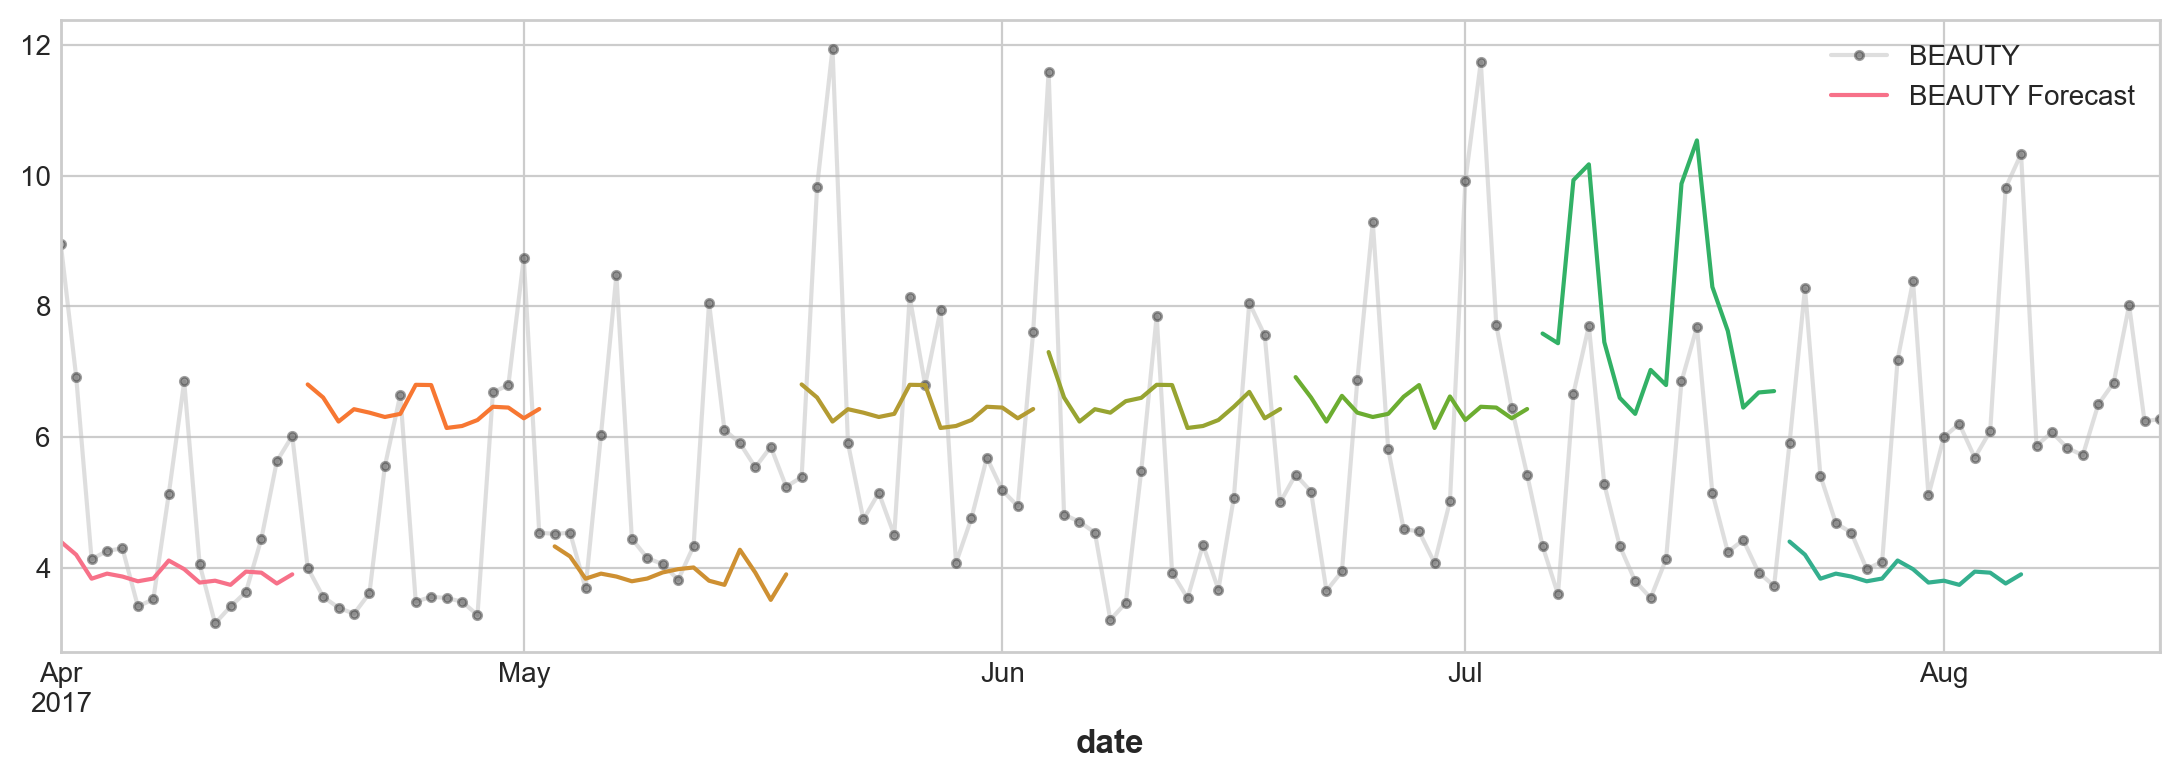

In [21]:
FAMILY = 'BEAUTY'
START = '2017-04-01'
EVERY = 16

y_pred_ = y_pred.xs(FAMILY, level='family', axis=0).loc[START:]
y_ = family_sales.loc[START:, 'sales'].loc[:, FAMILY]

fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax = y_.plot(**plot_params, ax=ax, alpha=0.5)
ax = plot_multistep(y_pred_, ax=ax, every=EVERY)
_ = ax.legend([FAMILY, FAMILY + ' Forecast'])